# Heathcote Model: Flopy Implementation

The following tutorial implements the heathcote model developed in the tutorials and assignment in Flopy.  

Flopy is a python package for creating, running, and postprocessing MODFLOW models.

# 1. Steady-state model

## 1.1 Setting up

First we will set up our directory. This is essential as MODFLOW requires a lot of input files and produces several output. 

In [1]:
import os

workspace = os.path.join("data", "mf")
if not os.path.exists(workspace):
    os.makedirs(workspace)

Next, let's define some parameters to use in our model. Recall that the conceptual Heathcote model has two boundary conditions. These are the **constant head** at the ocean, and **recharge** from rainfall.

In [2]:
chd_ocean = 0.
rch_rain = 20./1000./30.4375/24./60./60. # converting from [mm/month] to [m/s]

We also need to define some general properties of our discretization.

In [3]:
Nlay = 3
N = 40
L = 4000.
H = [-5., -60., -90.] # elevation of the bottom of each layer, [masl]

As well as the hydrailic properties of each aquifer. Note the tensor notation,    $k_{11} = k_{xx}$

In [4]:
k11_default = [2e-4, 1e-4, 1e-3] # k_xx in each of the layers
k11_channel = 1.
nu = 0.1 # ratio between vertical and horizontal conductivities

For the steady state problem we have a single stress period lasting one second

In [5]:
time_units = 'SECONDS'
period0 = [1., 1, 1.] # length, nsteps, multiplier

In ModelMuse, we created objects to define different areas in our model. Here, instead we will use predefined geometries which are characterized by vertices listed in a .csv file. 

In [6]:
# paths to the .csv files
contours = r"./objects/contours.csv" 
inactive = r"./objects/inactive.csv"
channel = r"./objects/channel.csv"
ocean = r"./objects/ocean.csv"

Now we have defined all the parameters we need, we will begin to create a model

## 1.2 Creating a MODFLOW simulation object

The MODFLOW 6 simulation structure is arranged in the following way:

**SIMULATION --> PACKAGE --> Data**  

**SIMULATION --> MODEL --> PACKAGE --> Data**

So we first need to create a MODFLOW simulation object, and then create a model within this simulation. These are some things that happened in the background when using ModelMuse,

In [7]:
import flopy 

In [8]:
name = "heathcote"

# create a simulation 
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    exe_name="mf6",
    version="mf6",
    sim_ws=workspace
)

# create a groundwater flow model
model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(
    sim, # defining which simulation this model belongs to.
    modelname=name,
    model_nam_file=model_nam_file,
    save_flows=True # this is important for particle tracking later
)

The first package we will create is the **temporal discretization**. For now we will consider the **steady state** problem. Note that this package is a attribute of the **simulation** rather than the object. 

In [9]:
tdis = flopy.mf6.ModflowTdis(
    sim,
    pname="tdis",
    time_units=time_units,
    nper=1,
    perioddata=period0
)

We also need a **iterative model solution**, which defines how the simulation is ran

In [10]:
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    complexity="SIMPLE"
)

Let's have a look at what we have created

In [11]:
sim

sim_name = heathcote
sim_path = P:\My Documents\flopy_tutorial\data\mf
exe_name = mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = heathcote


###################
Package tdis
###################

package_name = tdis
filename = heathcote.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = heathcote


###################
Package ims
###################

package_name = ims
filename = heathcote.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = heathcote


@@@@@@@@@@@@@@@@@@@@
Model heathcote
@@@@@@@@@@@@@@@@@@@@

name = heathcote
model_type = gwf6
version = mf6
model_relative_path = .



## 1.3 Defining the MODFLOW model

At the momemt we have created a model object, but we have not defined any of it's properties. We do this through creating packages within it.

First we will create a **discretization package** which defines the model grid. To do this we need to **interpolate** the top surface from the contour values described in the file contours.csv. We also need to specify which cells are inactive, using the object defined in inactive.csv

In [12]:
import numpy as np
from utils import * # import utilities for dealing with contours and objects

# create top of model elevation
top = surface_interpolation(contours, L, L/N)
bot = H
delrow = delcol = L/N

# creating a discretization package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=Nlay,
    nrow=N,
    ncol=N,
    delr=delrow,
    delc=delcol,
    top=top,
    botm=bot,
    xorigin=0.,
    yorigin=-L,
)

In [13]:
dis

package_name = dis
filename = heathcote.dis
package_type = dis
model_or_simulation_package = model
model_name = heathcote

Block options
--------------------
xorigin
{internal}
(0.0)

yorigin
{internal}
(-4000.0)


Block dimensions
--------------------
nlay
{internal}
(3)

nrow
{internal}
(40)

ncol
{internal}
(40)


Block griddata
--------------------
delr
{constant 100.0}

delc
{constant 100.0}

top
{internal}
(array([[ 35.14463681,  33.26265072,  31.38066464, ..., 102.42753327,
        108.28634678, 114.14516028],
       [ 35.81513422,  33.93314814,  32.05116206, ..., 108.88044465,
        114.73925815, 120.59807166],
       [ 36.48563163,  34.60364555,  32.72165947, ..., 115.33335602,
        121.19216953, 127.05098303],
       ...,
       [320.        , 320.        , 320.        , ..., 320.        ,
        320.        , 320.        ],
       [320.        , 320.        , 320.        , ..., 320.        ,
        320.        , 320.        ],
       [320.        , 320.        , 320. 

In [14]:
gwf.dis

package_name = dis
filename = heathcote.dis
package_type = dis
model_or_simulation_package = model
model_name = heathcote

Block options
--------------------
xorigin
{internal}
(0.0)

yorigin
{internal}
(-4000.0)


Block dimensions
--------------------
nlay
{internal}
(3)

nrow
{internal}
(40)

ncol
{internal}
(40)


Block griddata
--------------------
delr
{constant 100.0}

delc
{constant 100.0}

top
{internal}
(array([[ 35.14463681,  33.26265072,  31.38066464, ..., 102.42753327,
        108.28634678, 114.14516028],
       [ 35.81513422,  33.93314814,  32.05116206, ..., 108.88044465,
        114.73925815, 120.59807166],
       [ 36.48563163,  34.60364555,  32.72165947, ..., 115.33335602,
        121.19216953, 127.05098303],
       ...,
       [320.        , 320.        , 320.        , ..., 320.        ,
        320.        , 320.        ],
       [320.        , 320.        , 320.        , ..., 320.        ,
        320.        , 320.        ],
       [320.        , 320.        , 320. 

In [15]:
gwf.dis.nlay

{internal}
(3)

In [16]:
gwf.dis.nlay.data

3

We can also **change** or **add** data to a package using this method

For example, let's define the active cells in the model. We use a flopy utility called **grid intersect**, as well as an additional package called **shapely**.

In [17]:
from flopy.utils.gridintersect import GridIntersect
import shapely
from shapely.geometry.polygon import Polygon

# create grid intersection object
ix = GridIntersect(gwf.modelgrid, method='vertex')

vertices = np.genfromtxt(inactive, skip_header=1, delimiter=',') 
poly_inactive = Polygon(vertices)
inactive_cells = ix.intersects(poly_inactive)

# initialize all cells with 1 (active)
idomain = np.ones((N,N), dtype=int)

# set all inactive cells to 0 
for cell in inactive_cells: 
    idomain[cell.cellids[0]][cell.cellids[1]] = 0 
    
# duplicate for all layers    
idomain = np.array([idomain]*Nlay)

# add data to the discretization package
dis.idomain = idomain

The **Node Properties Flow** package contains the information on hydraulic conductivities, as well as the cell types (confined/unconfined). We'll find the cells in the gravel channel in the same way as we did the inactive region.

In [18]:
# setting hydraulic conductivity of cells in the gravel channel
vertices = np.genfromtxt(channel, skip_header=1, delimiter=',') 
poly_channel = Polygon(vertices)
channel_cells = ix.intersects(poly_channel)
k11_2 = np.ones((N,N), dtype=int)*k11_default[2] # k_11 in the confined aquifer
for cell in channel_cells: k11_2[cell.cellids[0]][cell.cellids[1]] = k11_channel
    
# creating arrays of conductivities
k = [k11_default[0], k11_default[1], k11_2] 

# create node flow properties
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=[1, 0, 0],
    k=k,
    k22=k,
    k33=[k[0]*nu, k[1]*nu, k[2]*nu]
)

> ### Aside 1
> The way we create this package is a good example of how data can be set in each package. Each parameter in the package can be set using a number of structures. These could be a scalar value, and 1D, 2D > or 3D array, or a more complex structure, such as an ordered dictionary, which we will touch on later.
>
>In the package defined below, the parameter **k** is specified using a 1D array. The first two elements, corresponding to the first two layers are scalar values, as $k_{xx}$ is constant in these layers. > However, in the unconfined aquifer, $k_{xx}$ is a different value in the gravel channel, so it's value needs to be specified for every element in the layer of the grid. Flopy will interpret these >parameters and define the values for the entire grid.

 ## 1.4 Applying boundary conditions to the model
 
 Now we have created a few packages within our model which define the properties of the model grid. Next we will add a couple more packages which apply the boundary conditions. The first of these is the constant head boundary condition.

> ### Aside 2
>
> When we apply a boundary condition it is not always to every stress period. For example, when solving the transient problem, the well extraction only occurs in the transient period. This means we don't > want to have to specify the value of the boundary condition for all periods. The way we get around this is to use an ordered dicitonary. This dictionary has the form:
>
> $\{key: value, \space key: value, \dots\}$
>
> Where the key specifies the stress period, and the value is the stress period data.

In [19]:
# find ocean cells
vertices = np.genfromtxt(ocean, skip_header=1, delimiter=',') 
poly_ocean = Polygon(vertices)
ocean_cells = ix.intersects(poly_ocean)

# create stress period data. This is an 2D array with each row applying the boundary condition to a single cell
# [layer_id, row_id, column_id, head, aux, name] where aux = 0
chd_ocean_spd = [[0, c.cellids[0], c.cellids[1], chd_ocean, 0, 'chd_ocean'] for c in ocean_cells]
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data={0: chd_ocean_spd}
)

In [20]:
chd

package_name = chd_0
filename = heathcote.chd
package_type = chd
model_or_simulation_package = model
model_name = heathcote

Block period
--------------------
stress_period_data
{internal}
(rec.array([((0, 7, 22), 0.), ((0, 7, 21), 0.), ((0, 7, 20), 0.),
           ((0, 6, 23), 0.), ((0, 6, 22), 0.), ((0, 6, 21), 0.),
           ((0, 6, 20), 0.), ((0, 5, 20), 0.), ((0, 5, 24), 0.),
           ((0, 5, 23), 0.), ((0, 5, 22), 0.), ((0, 5, 21), 0.),
           ((0, 5, 19), 0.), ((0, 4, 19), 0.), ((0, 4, 25), 0.),
           ((0, 4, 24), 0.), ((0, 4, 23), 0.), ((0, 4, 22), 0.),
           ((0, 4, 21), 0.), ((0, 4, 20), 0.), ((0, 4, 18), 0.),
           ((0, 3, 18), 0.), ((0, 3, 20), 0.), ((0, 3, 21), 0.),
           ((0, 3, 22), 0.), ((0, 3, 23), 0.), ((0, 3, 24), 0.),
           ((0, 3, 25), 0.), ((0, 3, 19), 0.), ((0, 2, 26), 0.),
           ((0, 2, 25), 0.), ((0, 2, 24), 0.), ((0, 2, 23), 0.),
           ((0, 2, 22), 0.), ((0, 2, 21), 0.), ((0, 2, 20), 0.),
           ((0, 2, 19), 0.), (

A similar package is created for the rainfall recharge

In [21]:
# apply to acll cells in the top layer of the active region
rch_spd = [[None]]*(N**2-inactive_cells.size)
count = 0
for i in range(N):
    for j in range(N):
        if idomain[0, i, j] == 1:
            rch_spd[count] = [0, i, j, rch_rain, 0, 'rch_rain']
            count += 1

rch = flopy.mf6.ModflowGwfrch(
    gwf, 
    stress_period_data={0: rch_spd}
)

Lastly we create a package for generating the head output

In [22]:
# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
   gwf,
   saverecord=saverecord,
   head_filerecord=head_filerecord,
   budget_filerecord=budget_filerecord,
   printrecord=printrecord
)

## 1.5 Writing and running the simulation

In [23]:
# initial conditions
ic = flopy.mf6.ModflowGwfic(
    gwf, 
    strt=[0, 0, 0]
)

sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model heathcote...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 56 based on size of stress_period_data
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 1232 based on size of stress_period_data
    writing package oc...
    writing package ic...


In [24]:
# run from python
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following  executable to run the model: C:\Users\ccl124\AppData\Local\Microsoft\WindowsApps\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 22 2020 09:26:42 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. A

## 1.6 Accessing and visualising the results

Some plotting imports

In [33]:
import matplotlib.pyplot as plt
import imageio

Because the .hds is a binary file, we need to use another flopy utility to read it

In [34]:
# grabbing head data
hds = flopy.utils.binaryfile.HeadFile(workspace + '/' + headfile) # create link to headfile
h = hds.get_data(kstpkper=(0, 0)) # access link (kstp = step n, kper = period n)

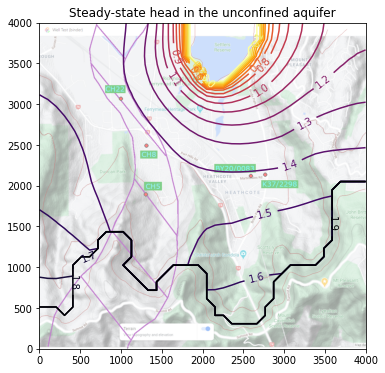

In [36]:
# plotting
x = y = np.linspace(0, L, N)
y = y[::-1]
fig0 = plt.figure(figsize=(6, 6))
img = imageio.imread(r"figures/topo.png")
ax = fig0.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], np.arange(0, 2.0, 0.1), cmap = 'inferno_r', zorder = 1)
plt.title('Steady-state head in the unconfined aquifer')
plt.clabel(c, fmt="%2.1f")
plt.imshow(img, zorder=0, extent = [0., 4000., 0., 4000.], alpha = 0.5)
plt.show()

# 2 Transient Model

## 2.1 Loading a model

It takes time to create a model and all the associated file. So it is useful to be able to load in a simulation. Let's imagine we hadn't just created a model

In [1]:
import flopy
import os
import matplotlib.pyplot as plt
import imageio
from flopy.utils.gridintersect import GridIntersect
import shapely
import numpy as np

name = "heathcote"
workspace = os.path.join("data", "mf")

sim = flopy.mf6.MFSimulation.load(name, version='mf6', sim_ws=workspace, exe_name="mf6")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package chd...
    loading package rch...
    loading package oc...
    loading package ic...
  loading ims package heathcote...


## 2.2 Setting up the data for the transient model

In [2]:
# new stress period data
period1l =  365.25*24*60*60 # length [seconds]
period1dt0 = 3155. # first time step
period1mult = 1.1 # time step multiplier

wells = r"./objects/wells.csv"

dch_wel = -0.04 # [m^3/s]

## 2.3 Updating model

First we will change the period data. Note that we have to create another python variable to point to the time discretization. This package already exist inside the simulation object, but we need to create a new link to it.

In [3]:
# first calculate the number of steps
nstp = np.log(period1l/period1dt0*(period1mult-1)+1)/np.log(period1mult)
period0 = (1., 1, 1.)
period1 = (period1l, nstp, period1mult)

# edit data 
tdis = sim.tdis
tdis.nper = 2
tdis.perioddata = [period0, period1]

And create a storage package:

In [4]:
gwf = sim.get_model()  # creating a new link to the gwf model
Nlay = gwf.dis.nlay.data

# create a package for the specific yield
sy = flopy.mf6.ModflowGwfsto.sy.empty(
    gwf,
    layered=True
)

for layer in range(Nlay):
    sy[layer]['data'] = 0.2

# create a package for the specific storage
ss = flopy.mf6.ModflowGwfsto.ss.empty(
    gwf,
    layered=True, 
    default_value=0.000001
)
                                                                          
sto = flopy.mf6.ModflowGwfsto(gwf, pname='sto', save_flows=True, iconvert=1,
                              ss=ss, sy=sy, steady_state={0:True},
                              transient={1:True})

To create the well package, we'll use another shapely package: **Point**

In [5]:
from shapely.geometry import Point
ix = GridIntersect(gwf.modelgrid, method='vertex')

# import data
wel_vertices = np.genfromtxt(wells, skip_header = 1, delimiter = ',')

# find the cell which is intersected by the well
wel_cells = ix.intersects(Point(wel_vertices[0], wel_vertices[1]))
wel_loc = (2, wel_cells['cellids'][0][0], wel_cells['cellids'][0][1])
wel_spd = {1:[wel_loc[0], wel_loc[1], wel_loc[2], dch_wel, 0, 'dch_well']} # ordered dictionary to specify data for stress period 1

wel = flopy.mf6.ModflowGwfwel(
    gwf,
    stress_period_data=wel_spd,
    pname = 'wel'
)

We'll also create an observation package. I've created all the relevent data, now you just need to build the package. These are some useful sources:

Class documentation: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfutlobs.html

Example of use: https://modflow6-examples.readthedocs.io/en/latest/_notebooks/ex-gwf-csub-p04.html?highlight=obs

In [6]:
# importing obs id
obs_wells = r"./objects/obs_wells.csv"
obs_vertices = np.genfromtxt(obs, skip_header = 1, delimiter = ',')

# intersect with grid
obs_cells = ix.intersects(Point(obs_vertices[0], obs_vertices[1]))

obs_loc = (2, obs_cells['cellids'][0][0], obs_cells['cellids'][0][1])

# create package
obs = flopy.mf6.ModflowUtlobs(
    
)

In [7]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package heathcote...
  writing model heathcote...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package chd_0...
    writing package rch_0...
    writing package oc...
    writing package ic...
    writing package sto...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package obs...


In [8]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following  executable to run the model: C:\Users\ccl124\AppData\Local\Microsoft\WindowsApps\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 22 2020 09:26:42 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. A

## 2.4 Visualising the cone of depression

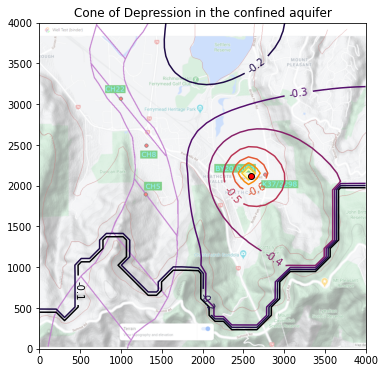

In [9]:
headfile = "{}.hds".format(name)
hds = flopy.utils.binaryfile.HeadFile(workspace + '/' + headfile)
h = hds.get_data(kstpkper=(71, 1)) - hds.get_data(kstpkper=(0, 0)) # finding the difference in heads

N = gwf.dis.nrow.data
L = N*gwf.dis.delr.data[0]
x = y = np.linspace(0, L, N)
y = y[::-1]
fig0 = plt.figure(figsize=(6, 6))
img = imageio.imread(r"figures/topo.png")
ax = fig0.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[2], np.arange(-0.9,-0,0.1), cmap = 'inferno_r', zorder = 1) # this time check out the confined aquifer
plt.title('Cone of Depression in the confined aquifer')
plt.clabel(c, fmt="%2.1f")
plt.imshow(img, zorder=0, extent = [0., 4000., 0., 4000.], alpha = 0.5)
plt.scatter(wel_vertices[0], 4000+wel_vertices[1], c='r', edgecolors='k')
plt.show()

## 2.5 Graphing the drawdown

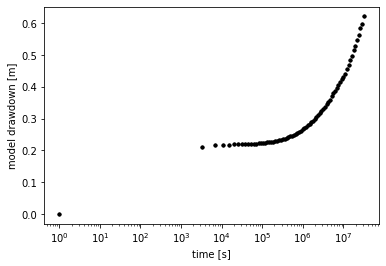

In [11]:
t,ch = np.genfromtxt(r'data/mf/0', skip_header=1, delimiter=',').T
f, ax1 = plt.subplots(1, 1)
ax1.plot(t,-(ch-ch[0]),'k.')
ax1.set_xlabel('time [s]')
ax1.set_ylabel('model drawdown [m]')
ax1.plot(t,-(ch-ch[0]),'k.')
ax1.set_xlabel('time [s]')
ax1.set_xscale('log')
plt.show()